In [1]:
import os
import re
import struct

import numpy as np
import pandas as pd
import scipy


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('poster',rc={"lines.linewidth": 1})

import gc # garbage collector

In [2]:
sev_file_path = r'D:\Work\data\sorting_test\20160710S8_Block-1_Raw1_Ch15.sev'

In [3]:
def read_sev(name):
    if os.path.isfile(name):
        fileName, fileExtension = os.path.splitext(name)
        if fileExtension.lower() != '.sev':
            print('not a valid SEV file')
            return
        print('importing data from single SEV file:', name)
    else:
        print('not a valid file')
        return None

    ALLOWED_FORMATS = [np.float32, np.int32, np.int16, np.int8, np.float64, np.int64]        
    
    f = open(name, 'rb')
    head = f.read(40)
        
    fileSizeBytes, fileType, fileVersion, eventName, channelNum, totalNumChannels, sampleWidthBytes, reserved1, dForm, decimate, rate, reserved2 = struct.unpack('Q3sB4sHHHHBBHQ',head)

    if fileType.decode().lower() != 'sev':
        print('bad file type'), fileType
        return None
        
    if fileVersion > 2:
        print('unknown version:'), fileVersion
        return None
        
    if fileVersion < 2:
        eventName = eventName[::-1]

    if fileVersion > 0:
        # determine data sampling rate
        print (type(rate), type(decimate))
        fs = 2.**(float(rate))*25000000./2.**12./float(decimate)
    else:
        dForm = 0
        fs = 0
        parts = sev_file.split('_')
        eventName = parts[-2]
        channelNum = int(re.search(r'\d+', parts[-1]).group())
        print('Warning - empty header; assuming {0} store, Ch {1} format {2} and fs',
               ' = {3}\nupgrade to OpenEx v2.18 or above for proper header',
               ' information\n'.format(eventName,  channelNum, dForm, 24414.0625))
        
        fs = 24414.0625

    fmt = ALLOWED_FORMATS[dForm & 7]
    
    d = dict()
    d['fileSizeBytes']    = fileSizeBytes
    d['fileType']         = fileType
    d['fileVersion']      = fileVersion
    d['eventName']        = eventName
    d['channelNum']       = channelNum
    d['totalNumChannels'] = totalNumChannels
    d['sampleWidthBytes'] = sampleWidthBytes
    d['dForm']            = dForm
    d['decimate']         = decimate
    d['rate']             = rate
    d['fs']               = fs
    d['fmt']              = fmt
    d['data']             = np.fromfile(f, dtype=fmt)
    
    if fileVersion > 0:
        # verify streamHeader is 40 bytes
        streamHeaderSizeBytes = d['fileSizeBytes'] - len(d['data']) * d['sampleWidthBytes'];
        if streamHeaderSizeBytes != 40:
            print('Warning - Header Size Mismatch -- {0} bytes vs 40 bytes'.format(streamHeaderSizeBytes))
            
    return d

#if __name__ == '__main__':
#    sev_file = '/path/to/sev'
#    d = read_sev(sev_file)
#    print d

In [4]:
d = read_sev(sev_file_path)

importing data from single SEV file: D:\Work\data\sorting_test\20160710S8_Block-1_Raw1_Ch15.sev
<class 'int'> <class 'int'>


In [5]:
d['data'] = d['data'][:int(len(d['data'])/10)]

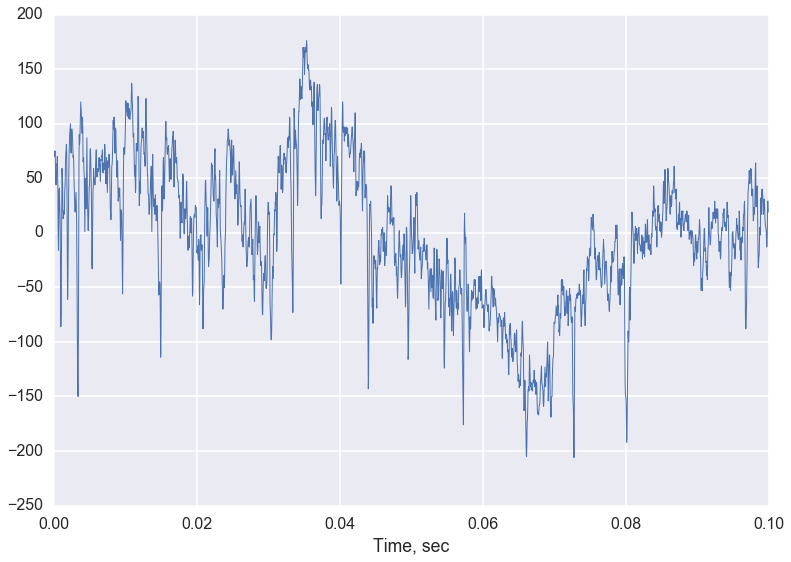

In [84]:
# sampling frequency
fs = d['fs']

# slice of 0.1 sec used to plot pieces of waveform for visual examination
fragment = slice(0,int(fs/10),1)

# time vector
t = np.arange(0,len(d['data']))/fs

plt.plot(t[fragment],d['data'][fragment])
plt.xlabel('Time, sec')
plt.show()

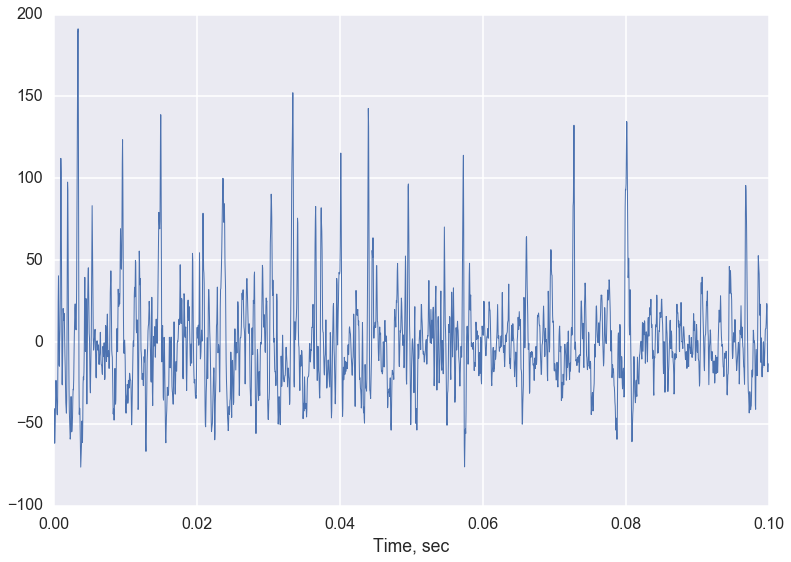

In [94]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Desired cutoff frequencies (in Hz).
lowcut = 200.0
highcut = 8000.0

data = butter_bandpass_filter(d['data'], lowcut, highcut, fs, order=4)
data = butter_bandpass_filter(np.flipud(data), lowcut, highcut, fs, order=4)
data = np.flipud(data)

# reflect data to have positive spike depolarization peaks
data = -data

plt.plot(t[fragment],data[fragment])
plt.xlabel('Time, sec')
plt.show()

In [95]:
def mad(x):
    """
    Returns the Median Absolute Deviation of its argument.
    """
    return np.median(np.absolute(x - np.median(x)))*1.4826

In [96]:
# center around median and normalize on median absolute deviation 
data = (data-np.median(data))/mad(data)

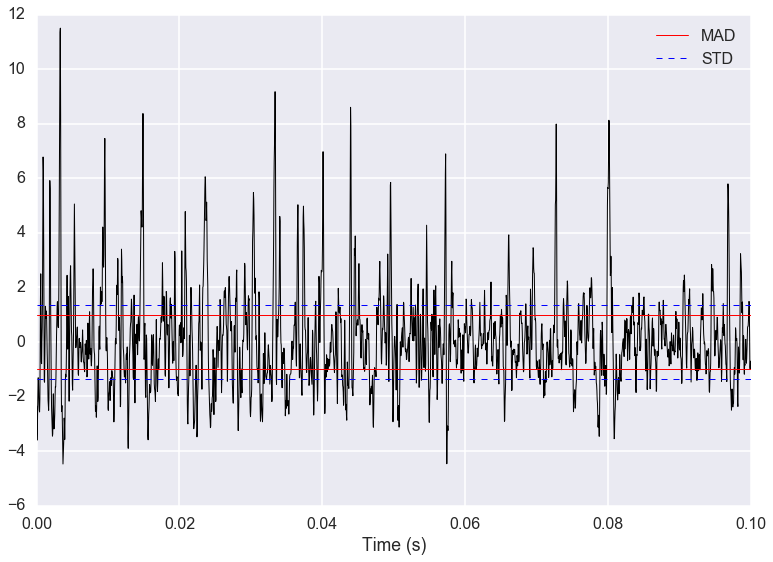

In [97]:
plt.plot(t[fragment],data[fragment],color="black",linewidth=1)
plt.axhline(y=1,color="red",label='MAD')
plt.axhline(y=-1,color="red")
plt.axhline(y=np.std(data),color="blue",linestyle="dashed",label='STD')
plt.axhline(y=-np.std(data),color="blue",linestyle="dashed")
plt.xlabel('Time (s)')
plt.legend(loc='best')
plt.show()

In [98]:
from scipy.signal import fftconvolve

# do running window average to smooth for peak detection
length_of_filter = 5
data_filtered = fftconvolve(data,np.array([1]*length_of_filter)/length_of_filter,'same')

# normalize on MAD estimate of STD
data_filtered = data_filtered/mad(data_filtered)

# rectify at threshold
threshold = 4
data_filtered[data_filtered < threshold] = 0

gc.collect()

152046

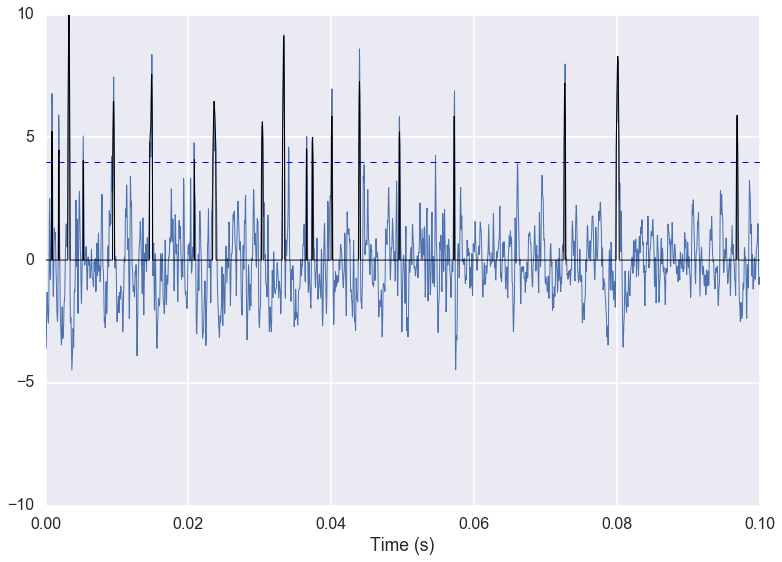

In [99]:
plt.plot(t[fragment], data[fragment])
plt.axhline(threshold,linestyle='dashed')
plt.plot(t[fragment], data_filtered[fragment],color='black')
plt.xlim([0,0.1])
plt.ylim([-10,10])
plt.xlabel('Time (s)')

plt.show()

In [100]:
def peak(x, minimal_dist=10, not_zero=1e-3):
    """
    Find peaks on one dimensional arrays.
    
    Parameters
    ----------
    x: a one dimensional array on which scipy.signal.fftconvolve can
       be called.
    minimal_dist: the minimal distance between two successive peaks.
    not_zero: the smallest value above which the absolute value of
    the derivative is considered not null.
    
    Returns
    -------
    An array of (peak) indices is returned.
    """
    ## Get the first derivative
    dx = scipy.signal.fftconvolve(x,np.array([1,0,-1])/2.,'same') 
    dx[np.abs(dx) < not_zero] = 0
    dx = np.diff(np.sign(dx))
    pos = np.arange(len(dx))[dx < 0]
    return pos[:-1][np.diff(pos) > minimal_dist]

In [101]:
# detect peaks
sp0 = peak(data_filtered)
print('Detected peaks: %s' % len(sp0))

Detected peaks: 29344


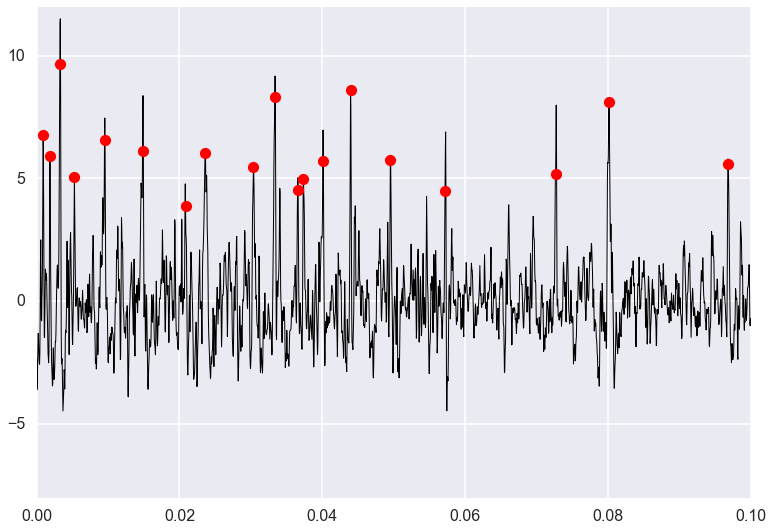

In [102]:
plt.plot(t[fragment],data[fragment],linewidth=1,color='black')
plt.plot(t[sp0],data[sp0],'ro')
plt.xlim([0,0.1])
plt.ylim([-8,12])
plt.show()

In [103]:
def cut_sgl_evt(evt_pos,data,before=14, after=30):
    """Cuts an 'event' at 'evt_pos' on 'data'.
    
    Parameters
    ----------
    evt_pos: an integer, the index (location) of the (peak of) the
             event.
    data: a matrix whose rows contains the recording channels.
    before: an integer, how many points should be within the cut
            before the reference index / time given by evt_pos.
    after: an integer, how many points should be within the cut
           after the reference index / time given by evt_pos.

    Returns
    -------
    A vector with the cuts on the different recording sites glued
    one after the other. 
    """
    ns = 1 ## Number of recording sites
    dl = data.shape[0] ## Number of sampling points
    cl = before+after+1 ## The length of the cut
    cs = cl*ns ## The 'size' of a cut
    cut = np.zeros((ns,cl))
    idx = np.arange(-before,after+1)
    keep = idx + evt_pos
    within = np.bitwise_and(0 <= keep, keep < dl)
    kw = keep[within]
    cut[:,within] = data[kw].copy()
    return cut.reshape(cs)

In [104]:
def mk_events(positions, data, before=14, after=30):
    """Make events matrix out of data and events positions.

    Parameters
    ----------
    positions: a vector containing the indices of the events.
    data: a matrix whose rows contains the recording channels.
    before: an integer, how many points should be within the cut
            before the reference index / time given by evt_pos.
    after: an integer, how many points should be within the cut
           after the reference index / time given by evt_pos.

    Returns
    -------
    A matrix with as many rows as events and whose rows are the cuts
    on the different recording sites glued one after the other. 
    """
    res = np.zeros((len(positions),(before+after+1)*1))
    for i,p in enumerate(positions):
        res[i,:] = cut_sgl_evt(p,data,before,after)
    return res

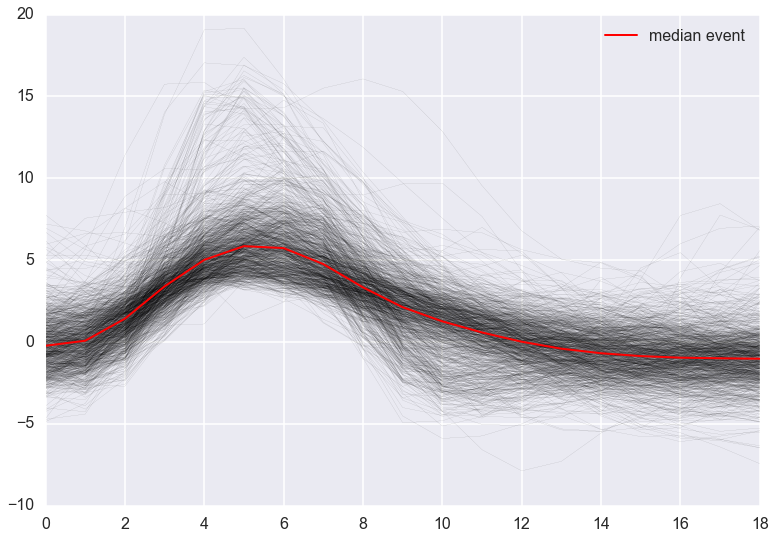

In [234]:
evtsE = pd.DataFrame(mk_events(sp0,data,5,13))
evtsE_median=evtsE.apply(np.median,0)

plt.plot(evtsE.sample(1000).transpose(),linewidth=0.05,c='k')
plt.plot(evtsE_median,linewidth=2,c='r',label='median event')
plt.legend(loc='best')
plt.show()

Perform principal component analysis on the waveforms

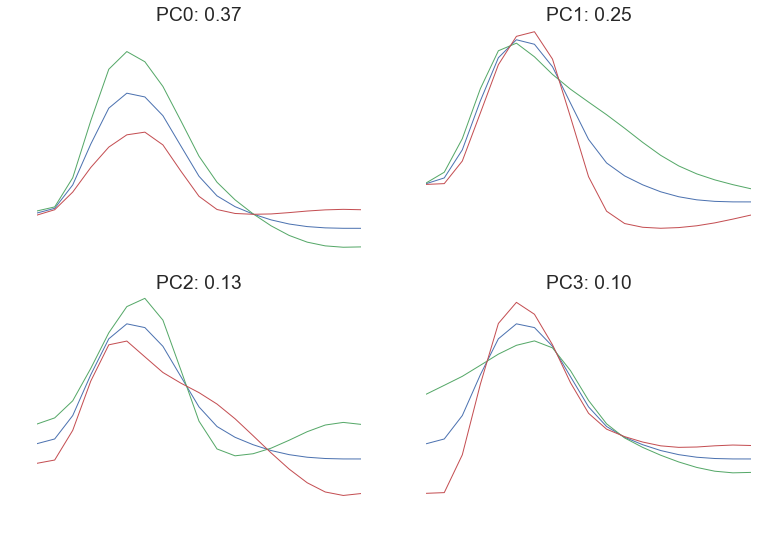

In [235]:
from sklearn.decomposition import PCA

waveform_pca = PCA(n_components=4)
waveform_pca.fit(evtsE)

# visualize components
waveform_mean = np.mean(evtsE,0)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(waveform_mean)
    plt.plot(waveform_mean + 5*waveform_pca.components_[i])
    plt.plot(waveform_mean - 5*waveform_pca.components_[i])
    plt.axis('off')
    plt.title('PC%s: %.4s' % (i, waveform_pca.explained_variance_ratio_[i]))

In [236]:
# calculate projections of all waveform onto the first 4 components
events_features = pd.DataFrame(np.dot(evtsE,waveform_pca.components_[:4].T), 
                               columns = ['PC%s' % i for i in range(4)])
events_features.head()

,PC0,PC1,PC2,PC3
0,7.515635,-0.361497,6.476457,-3.938349
1,9.340004,-7.764709,-0.196385,-4.453928
2,22.850631,-6.241012,4.841659,0.315103
3,7.205089,0.016828,2.634683,-2.787933
4,13.150495,-0.895653,5.164905,2.893987


In [237]:
## add event features
# peak amplitude
events_features['peak_amp'] = np.max(evtsE,axis=1)
# peak position
# events_features['peak_pos'] = evtsE.apply(np.argmax,axis=1)
# energy
# signal_energy = lambda x: np.sum(x**2)/len(x)
# events_features['energy'] = evtsE.apply(signal_energy,axis=1)

D:\Programs\Anaconda\envs\py35\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


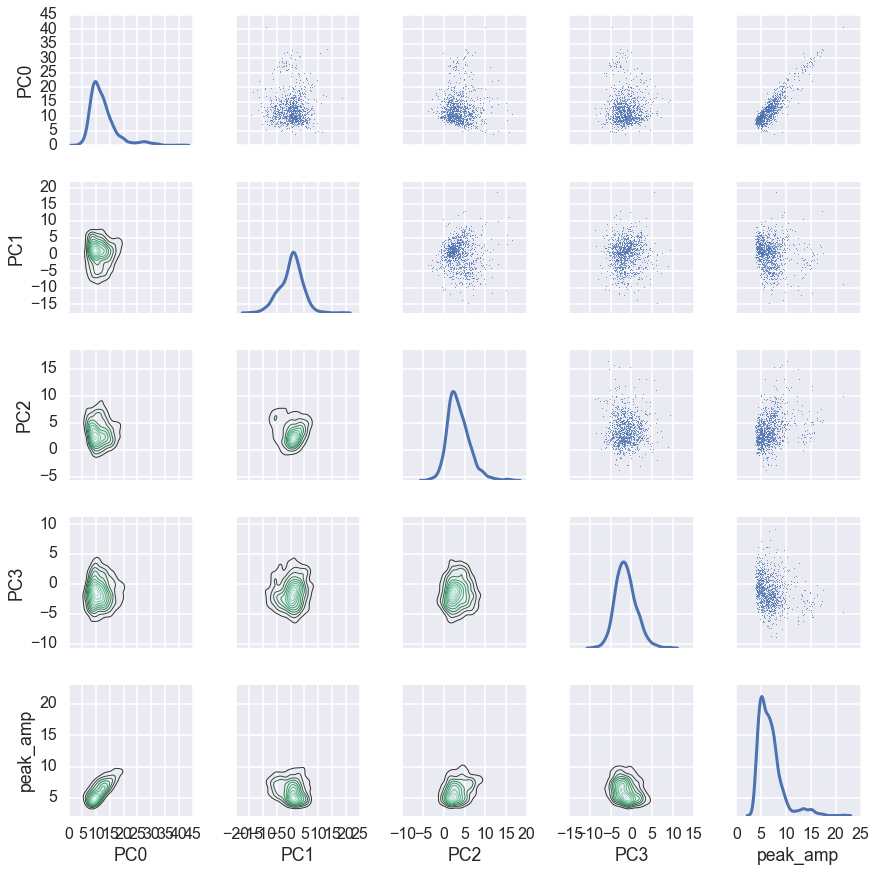

In [238]:
g = sns.PairGrid(events_features.sample(1000))
g = g.map_upper(plt.scatter,s=0.2)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(sns.kdeplot, lw=3, legend=False)

In [239]:
from sklearn.cluster import KMeans

In [254]:
km = KMeans(n_clusters=4,random_state=0).fit(events_features)
events_features_cl = events_features.copy()
events_features_cl['cl'] = km.labels_
print(events_features_cl.groupby('cl').count())

      PC0    PC1    PC2    PC3  peak_amp
cl                                      
0   13331  13331  13331  13331     13331
1    7401   7401   7401   7401      7401
2    7055   7055   7055   7055      7055
3    1557   1557   1557   1557      1557


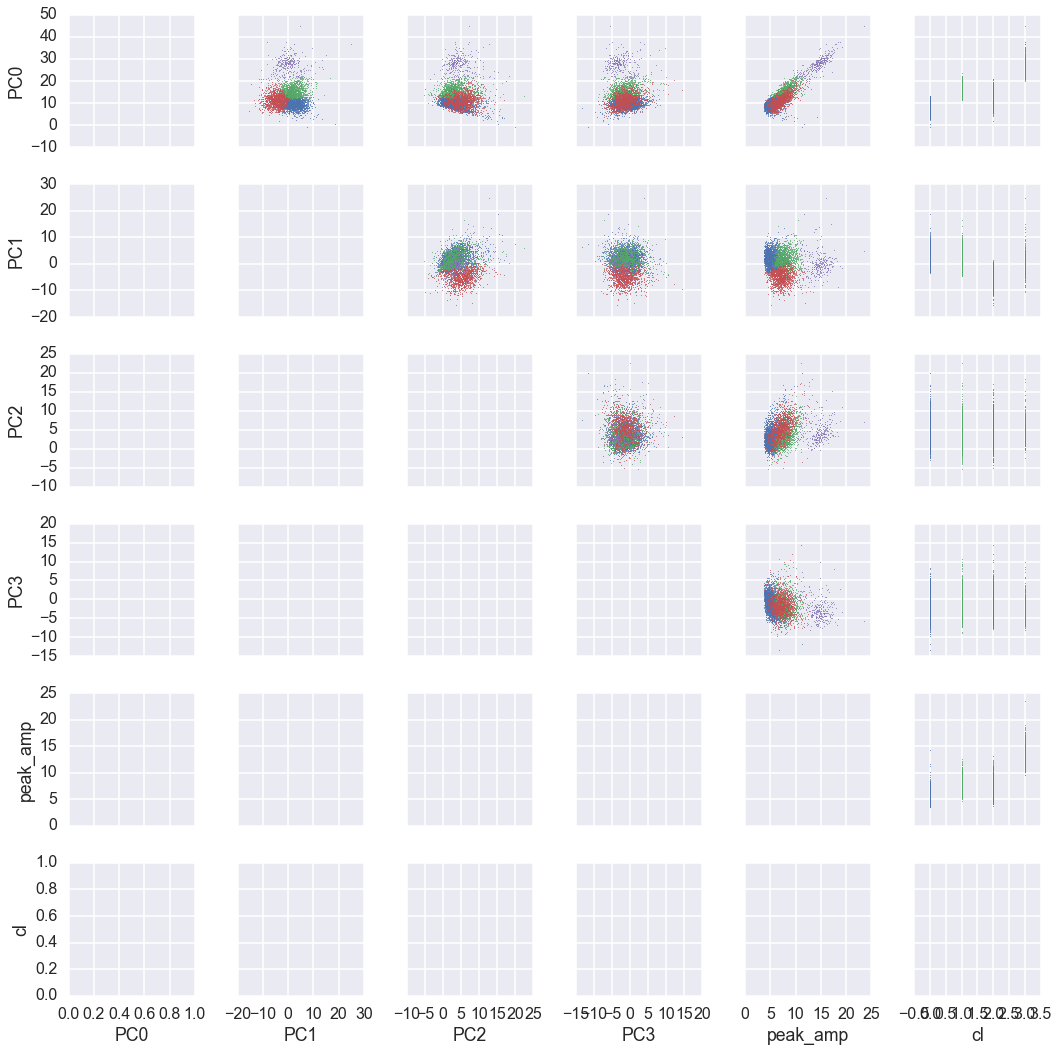

In [258]:
g = sns.PairGrid(events_features_cl.sample(5000),hue='cl')
g = g.map_upper(plt.scatter,s=0.2)

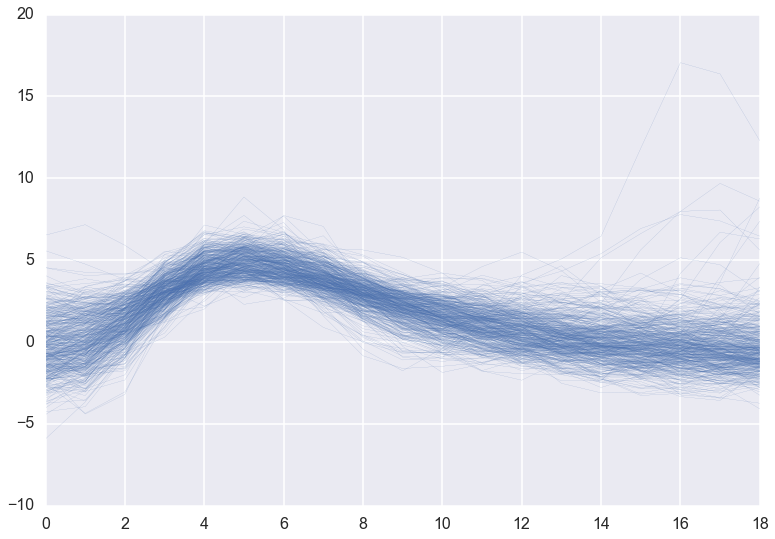

In [256]:
plt.plot(evtsE.loc[events_features_cl.cl==0].sample(500).T,color=sns.color_palette()[0],linewidth=0.1)
plt.show()

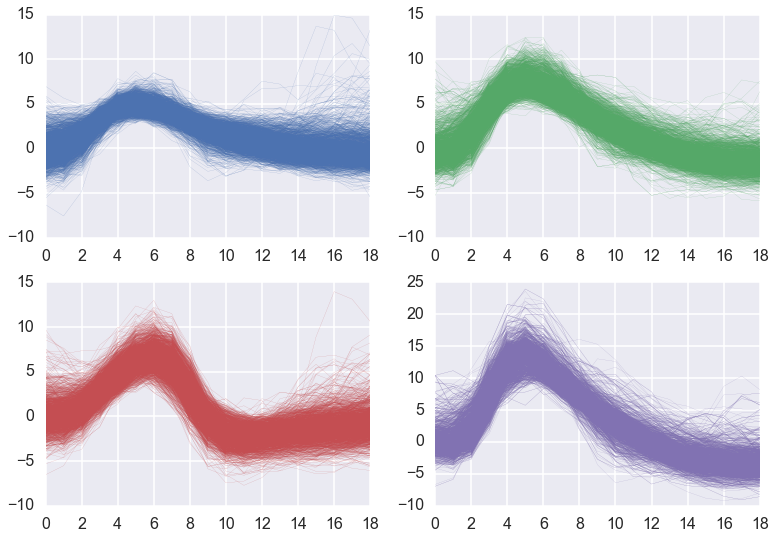

In [259]:
for cl in np.sort(events_features_cl.cl.unique()):
    for i in range(4):
        plt.subplot(2,2,cl+1)
        plt.plot(evtsE.loc[events_features_cl.cl==cl].sample(500).T,color=sns.color_palette()[cl],linewidth=0.1)
plt.show()

In [119]:
from sklearn.cluster import DBSCAN

In [192]:
from itertools import product
for (eps, min_samples) in product([0.5,1,1.5,2,2.5,3,3.5,4],[5,10,15,20,25,30,35,40]):
    db = DBSCAN(eps=eps,min_samples=min_samples,n_jobs=8).fit(events_features.drop(['cl'],axis='columns'))
    events_features['cl'] = db.labels_
    print('Max distance: %s' % eps,
          'Min samples core: %s' % min_samples)
    print(events_features.groupby('cl').count())

Max distance: 0.5 Min samples core: 5
        PC0    PC1    PC2    PC3  peak_amp
cl                                        
-1    28531  28531  28531  28531     28531
 0        7      7      7      7         7
 1       10     10     10     10        10
 2       19     19     19     19        19
 3        5      5      5      5         5
 4       25     25     25     25        25
 5        4      4      4      4         4
 6       12     12     12     12        12
 7       56     56     56     56        56
 8       18     18     18     18        18
 9        5      5      5      5         5
 10       7      7      7      7         7
 11       8      8      8      8         8
 12      11     11     11     11        11
 13       8      8      8      8         8
 14       7      7      7      7         7
 15       6      6      6      6         6
 16       5      5      5      5         5
 17       8      8      8      8         8
 18       7      7      7      7         7
 19       6     

In [194]:
db = DBSCAN(eps=3,min_samples=35,n_jobs=8).fit(events_features.drop(['cl'],axis='columns'))
events_features['cl'] = db.labels_
print(events_features.groupby('cl').count())

      PC0    PC1    PC2    PC3  peak_amp
cl                                      
-1   1783   1783   1783   1783      1783
 0  26738  26738  26738  26738     26738
 1    823    823    823    823       823


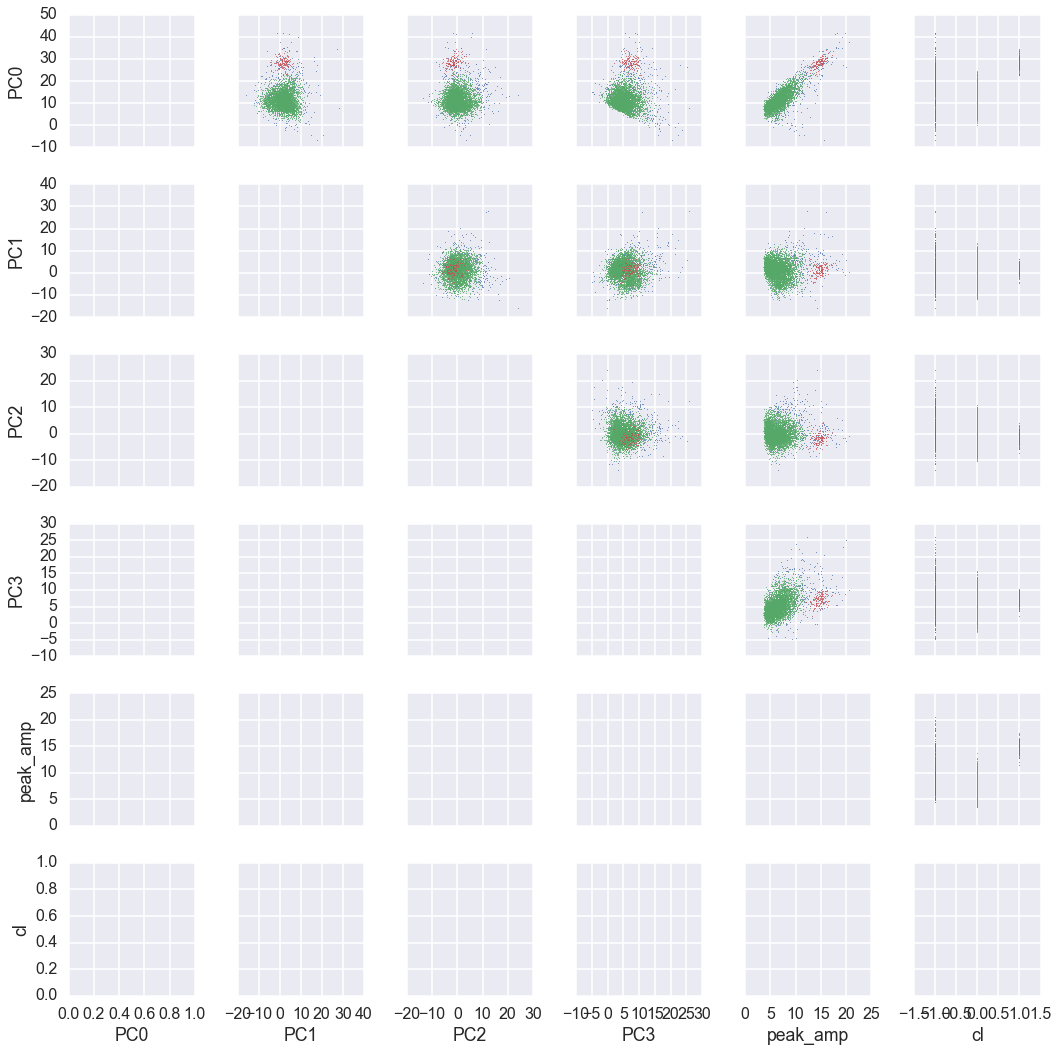

In [195]:
g = sns.PairGrid(events_features.sample(5000),hue='cl')
g = g.map_upper(plt.scatter,s=0.2)
# g = g.map_lower(sns.kdeplot)
# g = g.map_diag(sns.kdeplot, lw=3, legend=False)

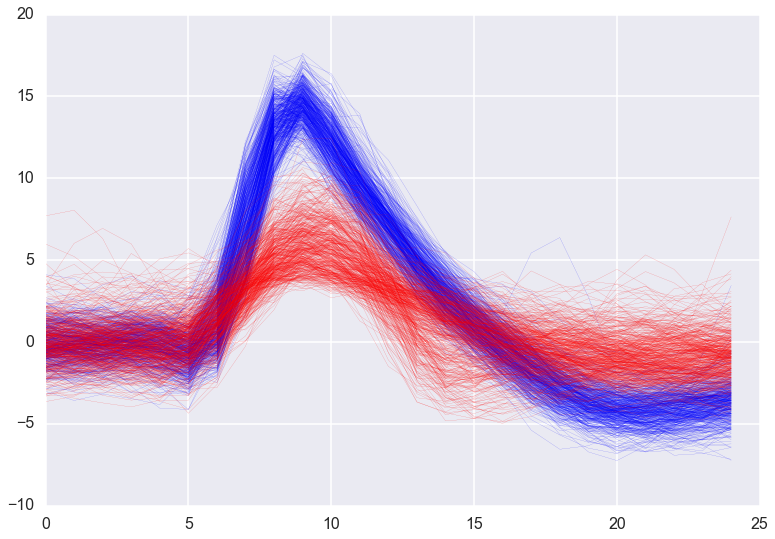

In [205]:
plt.plot(evtsE.loc[events_features.cl==1].sample(500).T,color='b',linewidth=0.1)
plt.plot(evtsE.loc[events_features.cl==0].sample(500).T,color='r',linewidth=0.1)
plt.show()

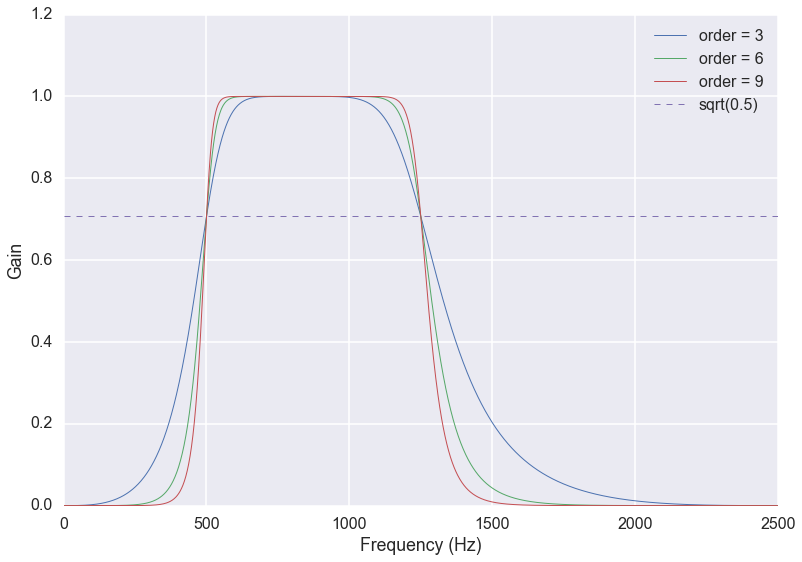

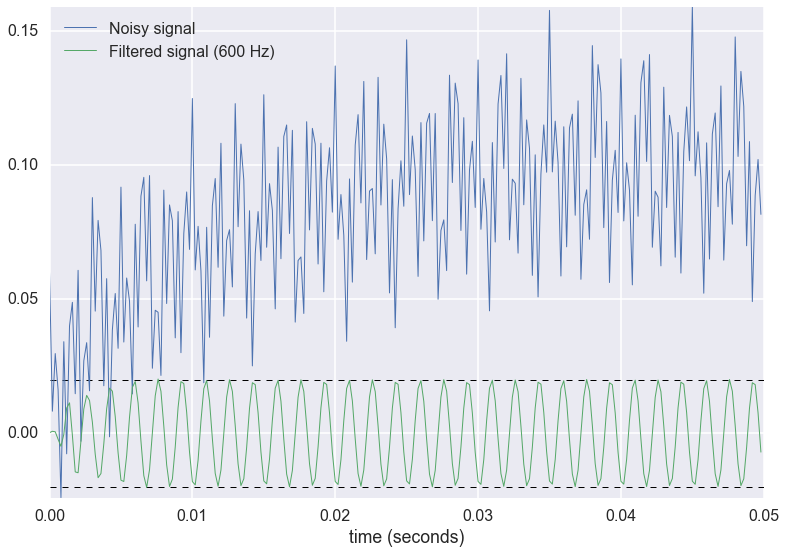

In [96]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()